# Node-based heterogeneous model optimization using an evolutionary approach

In the previous tutorial we fitted a **map-based heterogeneous** model in which a set of fixed biological maps were combined with bias terms and coefficients (as optimization free parameters) to determine the regional values of parameters $w_i^{p}$ and $J_i^{N}$ in each simulation. 

In this tutorial we use an alternative approach to determine the heterogeneity of regional parameters. In this approach, we define groups of nodes (based on e.g., canonical resting state networks (RSNs), bilateral homologous regions, or even setting each individual node as its own group) and let the regional parameters of each node group to vary independently (within a pre-defined range). We call this approach **node-based heterogeneity** to differentiate it from the map-based heterogeneity.

Here, we will use the map of seven canonical resting-state networks shown below to define the groups that each of the BNM nodes (in the Schaefer-100 parcellation) belong to. 

<div style="text-align: center;">
  <img src="yeo.png" width="500"/>
</div>


We then let each of the seven networks to have its own independent $w_i^{p}$ and $J_i^{N}$ value. Hence, from the optimization's point of view, together with $G$ (global coupling), we will have 15 tunable free parameters. This makes this model more high-dimensional than the map-based heterogeneous model used in the previous tutorial, which had 7 tunable free parameters.

## Loading the network assignments

We can load the map of seven RSNs (`'yeo7'`) in the Schaefer-100 parcellation using `cubnm.datasets.load_maps`:

In [1]:
from cubnm import datasets

yeo_map = datasets.load_maps('yeo7', parc='schaefer-100').astype(int)[0]
print("Shape of the map", yeo_map.shape)
yeo_map

Shape of the map (100,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

This is a 1D NumPy array of shape `(n_nodes,)` which defines the index of the **node group** that each node belongs to. Here we have seven groups indexed from 0 to 6. For example, the first node belongs to the group `0` (the "Visual Network") and the last node belongs to group `6` (the "Default Mode Network").

## Defining a node-based heterogeneous BNM problem

We next define a node-based heterogeneous `BNMProblem`. To do this, we need to pass the `yeo_map` as the `node_grouping` array, and define that we want `'w_p'` and `'J_N'` to heterogeneously vary according to this map (i.e., define them as the `het_params`). All other arguments to `BNMProblem`, including the empirical data and simulation options, remain similar to those used in the [homogeneous BNM problem](cmaes_homo.ipynb).

In [2]:
from cubnm import optimize

# load structural connectome
sc = datasets.load_sc('strength', 'schaefer-100', 'group-train706')
# load empirical FC tril and FCD tril
emp_fc_tril = datasets.load_fc('schaefer-100', 'group-train706', exc_interhemispheric=True, return_tril=True)
emp_fcd_tril = datasets.load_fcd('schaefer-100', 'group-train706', exc_interhemispheric=True, return_tril=True)

sim_options = dict(
    duration=900,
    bold_remove_s=30,
    TR=0.72,
    sc=sc,
    sc_dist=None,
    dt='0.1',
    bw_dt='1.0',
    states_ts=False,
    states_sampling=None,
    noise_out=False,
    sim_seed=0,
    noise_segment_length=30,
    gof_terms=['+fc_corr', '-fcd_ks'],
    do_fc=True,
    do_fcd=True,
    window_size=30,
    window_step=5,
    fcd_drop_edges=True,
    exc_interhemispheric=True,
    bw_params='heinzle2016-3T',
    sim_verbose=False,
    do_fic=True,
    max_fic_trials=0,
    fic_penalty_scale=0.5,
)

# define the **node-based heterogeneous** problem
problem = optimize.BNMProblem(
    model = 'rWW',
    params = {
        'G': (0.001, 10.0), 
        'w_p': (0, 2.0),
        'J_N': (0.001, 0.5)
    },
    emp_fc_tril= emp_fc_tril,
    emp_fcd_tril= emp_fcd_tril,
    het_params = ['w_p', 'J_N'],
    node_grouping = yeo_map,
    out_dir = './cmaes_yeo',
    **sim_options
)

We can inspect the list of free parameters defined in the `problem`:

In [3]:
problem.free_params

['G',
 'w_p0',
 'w_p1',
 'w_p2',
 'w_p3',
 'w_p4',
 'w_p5',
 'w_p6',
 'J_N0',
 'J_N1',
 'J_N2',
 'J_N3',
 'J_N4',
 'J_N5',
 'J_N6']

This shows that the model has 15 free parameters, including:

- `'G'`: The global coupling parameter, same as with the homogeneous models.
- `'w_p{g}'`: $w^{p}$ for each of the seven node groups `0` to `6`.
- `'J_N{g}'`: $J^{N}$ for each of the seven node groups `0` to `6`.

<div class="alert alert-info">
<p>
The `free_params` listed in `BNMProblem` represent the <b>tunable high-level parameters</b> for optimization. These differ from the lower-level model parameters in `SimGroup`, which include:
<ul>
    <li>`'G'`</li>
    <li>Node-specific values (N = number of nodes) for `'w_p'`, `'J_N'`, `'sigma'` and `'wIE'` (the latter is internally determined by the FIC algorithm and set to zero during setup).</li>
</ul>
</p>
</div>

## Model optimization

Next, we should use an optimizer to fit the free model parameters to the target empirical data. Given the high dimensionality of this optimization problem with 15 free parameters, it will be nearly impossible to do the optimization using `GridOptimizer`. Therefore it is more appropriate to use evolutionary optimization algorithms such as CMA-ES.

We will now run a CMA-ES optimization via `CMAESOptimizer`. As with the previous tutorials we will use a maximum of `n_iter=120` iterations, with early stopping based on `tolfun=5e-3`, using `popsize=128` particles per generation, and with the sampling random `seed=1`.

In [4]:
%%time
# initialize the optimizer
cmaes = optimize.CMAESOptimizer(    
    popsize=128,
    n_iter=120, 
    seed=1,
    algorithm_kws=dict(tolfun=5e-3),
    print_history=False
)
# assign the high-dimensional problem to it
cmaes.setup_problem(problem)

# run the optimization
cmaes.optimize()

# save the results (which reruns the optimal simulation)
out_path = cmaes.save()

Initializing GPU session...
took 3.165339 s
Running 128 simulations...
took 40.278010 s
Current session is already initialized
Running 128 simulations...
took 40.966734 s
Current session is already initialized
Running 128 simulations...
took 40.961245 s
Current session is already initialized
Running 128 simulations...
took 40.529585 s
Current session is already initialized
Running 128 simulations...
took 39.386008 s
Current session is already initialized
Running 128 simulations...
took 39.396303 s
Current session is already initialized
Running 128 simulations...
took 39.239515 s
Current session is already initialized
Running 128 simulations...
took 40.522250 s
Current session is already initialized
Running 128 simulations...
took 39.433876 s
Current session is already initialized
Running 128 simulations...
took 40.965362 s
Current session is already initialized
Running 128 simulations...
took 40.962941 s
Current session is already initialized
Running 128 simulations...
took 40.951449 s

Unlike the CMA-ES runs for the homogeneous model (3 tunable parmaeters) and map-based heterogeneous model (7 tunable parameters), the optimization for this model with 15 tunable parameters did not fully converge before reaching the specified maximum 120 generations. This is not unexpected, since this model has a higher number of parameters and therefore is more difficult to fit. 

When `cmaes.save()` is called, the optimal simulation is re-run so that its simulated data can be saved to disk. For a detailed description of the saved files, see the [grid search tutorial](grid_search.ipynb).

## Visualization of the optimization history

The parameters of all simulations (particles) run during the optimization, along with their associated cost function and its components, are stored in `cmaes.history`.

In [5]:
cmaes.history

,index,G,w_p0,w_p1,w_p2,w_p3,w_p4,w_p5,w_p6,J_N0,...,J_N3,J_N4,J_N5,J_N6,cost,+fc_corr,-fcd_ks,+gof,-fic_penalty,gen
0,0,1.472567,1.435512,1.671699,1.367991,0.728869,1.158532,0.096821,1.496528,0.316592,...,0.209846,0.420515,0.311622,0.069113,0.126766,0.211213,-0.220574,-0.009361,-0.117405,1
1,1,0.143196,1.651506,1.236474,1.913307,1.888697,0.122902,1.370109,0.732970,0.474577,...,0.323992,0.124904,0.206408,0.351788,0.715247,0.214684,-0.922239,-0.707555,-0.007691,1
2,2,3.004649,0.897253,0.066734,0.968572,0.663693,0.020292,0.350292,0.241528,0.187417,...,0.392479,0.307041,0.203136,0.221752,1.010965,0.296057,-0.882833,-0.586777,-0.424188,1
3,3,6.564782,0.827424,0.745345,1.050029,0.916899,0.781033,0.550005,1.106613,0.190027,...,0.348574,0.093330,0.434494,0.400440,1.222165,0.174892,-0.918672,-0.743780,-0.478385,1
4,4,4.151323,1.965671,0.363197,0.404394,1.204167,0.077901,1.658216,1.745880,0.073936,...,0.166101,0.216128,0.295292,0.113545,1.012420,0.233579,-0.878617,-0.645038,-0.367382,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15355,123,1.261561,0.005023,1.173868,1.247661,0.496778,0.139569,1.282338,0.020614,0.257995,...,0.478924,0.001223,0.092154,0.065937,-0.334041,0.520926,-0.172857,0.348069,-0.014028,120
15356,124,1.292278,0.015717,1.229793,1.113088,0.247134,0.001068,1.369506,0.009772,0.243074,...,0.471313,0.001452,0.086233,0.069401,-0.336822,0.521184,-0.171194,0.349990,-0.013168,120
15357,125,1.254408,0.000444,1.225396,1.131937,0.285732,0.005609,1.517080,0.000069,0.282855,...,0.483512,0.001050,0.084717,0.069215,-0.333561,0.520264,-0.174104,0.346160,-0.012599,120
15358,126,1.286507,0.002836,1.239147,1.042208,0.413772,0.039593,1.300840,0.004751,0.281421,...,0.485616,0.001023,0.091959,0.063851,-0.335103,0.520851,-0.173256,0.347595,-0.012492,120


We can visualize how negative cost evolved over the course of CMA-ES optimization. Here, to indicate better simulations with higher values, rather than the cost function we will visualize negative cost function.

<Axes: xlabel='Generation', ylabel='- Cost'>

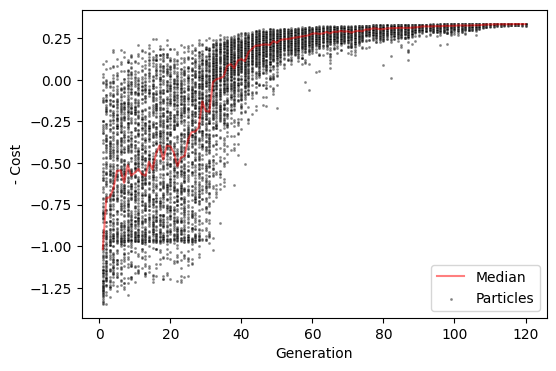

In [6]:
cmaes.plot_history('-cost')

With respect to negative cost variability, the optimization seems to be close to convergence, but not yet converged. Therefore the optimization can be potentially run with a higher maximum number of iterations (at the cost of higher compute time).

We can also visualize how the global parameter $G$ and the regional values of parameters $w_i^{p}$ and $J_i^{N}$ evolve throughout the optimization using a GIF.

<div class="alert alert-info">
<p>
Note: The `cmaes.history` object stores only the 7 free parameters from the optimizer's point of view (i.e., `G` and baseline and map coefficients used for calculating regional parameters). To visualize the actual regional parameters in the code below, we must recalculate them. To do this, we use the `_get_X()` to convert the 7 free parameters explored through optimization history to the normalized parameter space, and then pass them to `_get_sim_params()` methods to transform the high-level parameters into full model parameter arrays for each particle. This is just a hack used for preparing the data used in the GIF, and is not needed during normal usage.
</p>
</div>

In [7]:
# transform history parameters to normalized space
hist_X = cmaes.problem._get_X(cmaes.history.loc[:, cmaes.problem.free_params])
# convert optimizer parameters (n = 15) to model parameters (n = 1 + 100 + 100)
# by calling `_get_sim_params()` method
hist_params = cmaes.problem._get_sim_params(hist_X)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imageio
import os
import tempfile
from tqdm import tqdm

# initialize the frames and temporary directory
frames = []
temp_dir = tempfile.mkdtemp()

# set a unified vmin and vmax for all the heatmaps
# note that upper limit is set to 95th percentile
# as there are some extreme outliers in the initial generations
# making the patterns in subsequent generations unclear
vmins = {
    'G': hist_params['G'].min(),
    'w_p': hist_params['w_p'].min(),
    'J_N': hist_params['J_N'].min()
}
vmaxs = {
    'G': np.quantile(hist_params['G'], 0.95),
    'w_p': np.quantile(hist_params['w_p'], 0.95),
    'J_N': np.quantile(hist_params['J_N'], 0.95)
}

# loop through each generation and save a frame
for gen in tqdm(range(cmaes.history['gen'].min(), cmaes.history['gen'].max() + 1)):
    # get the index of simulations in current generation
    curr_gen_idx = cmaes.history.loc[cmaes.history['gen']==gen].index
    if len(curr_gen_idx) < cmaes.popsize:
        continue
    # create the axes
    fig, axd = plt.subplot_mosaic(
        [["G"] + ["space0"] + ["w_p"] * 100 + ["title"] + ["J_N"] * 100],
        gridspec_kw=dict(width_ratios=[10] + [1] * 202),
        figsize=(6, 3), dpi=80
    )
    # plot separate heatmaps for each parameter
    sns.heatmap(hist_params['G'][curr_gen_idx, None], ax=axd['G'], cbar=False, cmap='viridis', vmin=vmins['G'], vmax=vmaxs['G'])
    axd['G'].set_title(r'$G$')
    sns.heatmap(hist_params['w_p'][curr_gen_idx, :], ax=axd['w_p'], cbar=False, cmap='viridis', vmin=vmins['w_p'], vmax=vmaxs['w_p'])
    axd['w_p'].set_title(r'$w^{p}$')
    sns.heatmap(hist_params['J_N'][curr_gen_idx, :], ax=axd['J_N'], cbar=False, cmap='viridis', vmin=vmins['J_N'], vmax=vmaxs['J_N'])
    axd['J_N'].set_title(r'$J^{N}$')
    # aesthetics
    axd['title'].set_title(f'Generation {gen}')
    for ax in axd.values():
        ax.axis('off')
    fig.subplots_adjust(wspace=0.5)
    # save frame
    frame_path = os.path.join(temp_dir, f'frame_{gen}.png')
    plt.savefig(frame_path)
    frames.append(frame_path)
    plt.close(fig)

# create the GIF
images = [imageio.imread(frame) for frame in frames]
imageio.mimsave('./cmaes_yeo.gif', images, fps=2, loop=0)


  0%|          | 0/120 [00:00<?, ?it/s]

  1%|          | 1/120 [00:00<01:24,  1.40it/s]

  2%|▏         | 2/120 [00:01<01:12,  1.62it/s]

  2%|▎         | 3/120 [00:01<01:08,  1.71it/s]

  3%|▎         | 4/120 [00:02<01:05,  1.76it/s]

  4%|▍         | 5/120 [00:02<01:04,  1.79it/s]

  5%|▌         | 6/120 [00:03<01:08,  1.66it/s]

  6%|▌         | 7/120 [00:04<01:05,  1.72it/s]

  7%|▋         | 8/120 [00:04<01:03,  1.75it/s]

  8%|▊         | 9/120 [00:05<01:02,  1.78it/s]

  8%|▊         | 10/120 [00:05<01:01,  1.79it/s]

  9%|▉         | 11/120 [00:06<01:00,  1.80it/s]

 10%|█         | 12/120 [00:06<00:59,  1.81it/s]

 11%|█         | 13/120 [00:07<01:04,  1.66it/s]

 12%|█▏        | 14/120 [00:08<01:01,  1.71it/s]

 12%|█▎        | 15/120 [00:08<01:00,  1.75it/s]

 13%|█▎        | 16/120 [00:09<00:58,  1.77it/s]

 14%|█▍        | 17/120 [00:09<00:57,  1.79it/s]

 15%|█▌        | 18/120 [00:10<00:56,  1.80it/s]

 16%|█▌        | 19/120 [00:10<00:55,  1.81it/s]

 17%|█▋        | 

![CMAES GIF](./cmaes_yeo.gif)

In this visualization, each row represents one particle (i.e., one simulation in a generation). For $w_i^{p}$ and $J_i^{N}$, each column corresponds to a node in the simulation. We observe that, toward the end of the optimization, the regional parameters are beginning to stabilize into consistent spatial patterns, indicating convergence to a heterogeneous configuration that best fits the empirical data.

## Visualization of the optimal simulation

Lastly, we will visualize the simulated FC and FCD of the optimal simulation and compare them to the empirical data.

We can then plot the empirical FC next to the simulated FC. Note that at the end of the single-objective optimizations such as CMA-ES, `cmaes.problem.sim_group` contains a single simulation which is the optimum, therefore we can access its data by providing `0` as the simulation index.

Text(0.5, 1.0, 'Simulated FC')

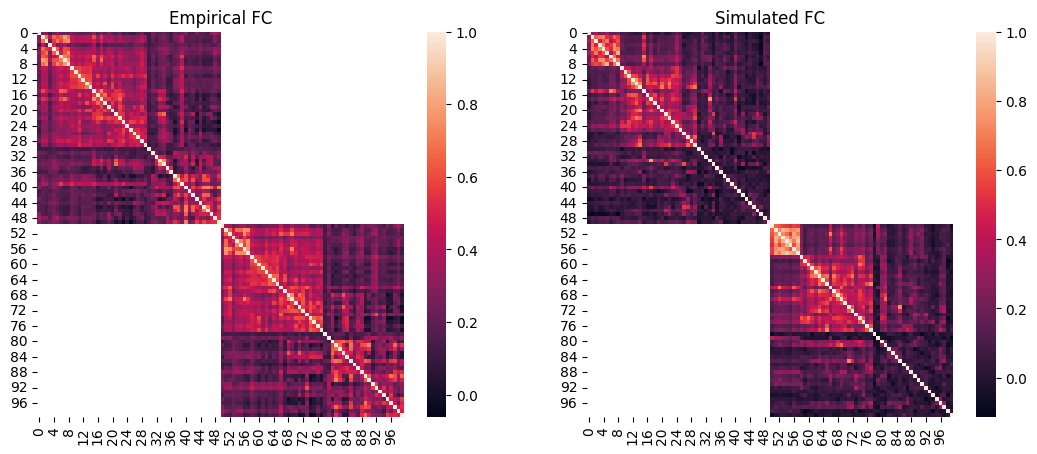

In [9]:
import seaborn as sns

# load the squared form of the empirical FC
emp_fc = datasets.load_fc('schaefer-100', 'group-train706', exc_interhemispheric=True, return_tril=False)

opt_idx = 0

# load squared form of optimal simulated FC
sim_fc = cmaes.problem.sim_group.get_sim_fc(opt_idx)

# plot it next to the empirical FC
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(emp_fc, ax=axes[0])
axes[0].set_title("Empirical FC")
sns.heatmap(sim_fc, ax=axes[1])
axes[1].set_title("Simulated FC")

FC correlation = 0.5209592523551861


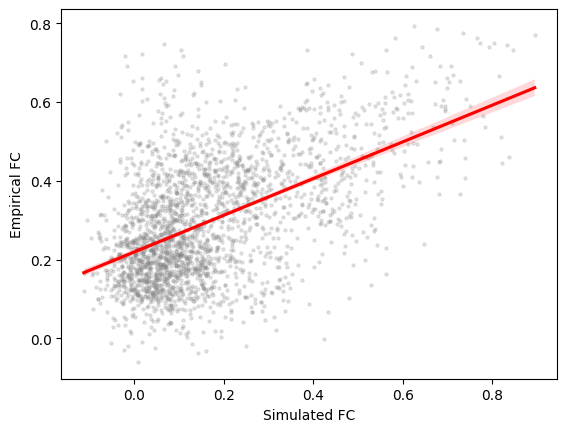

In [10]:
import scipy.stats
# regression plot
fig, ax = plt.subplots()
sns.regplot(
    x=cmaes.problem.sim_group.sim_fc_trils[opt_idx],
    y=emp_fc_tril,
    scatter_kws=dict(s=5, alpha=0.2, color="grey"),
    line_kws=dict(color="red"),
)
ax.set_xlabel("Simulated FC")
ax.set_ylabel("Empirical FC")
# calculate Pearson correlation
print(f"FC correlation = {scipy.stats.pearsonr(cmaes.problem.sim_group.sim_fc_trils[opt_idx], emp_fc_tril).statistic}")

In addition to static FC, we can also plot the simulated FCD matrix distribution next to the empirical data, and calculate their Kolmogorov-Smirnov distance:

FCD KS distance = 0.16995461741311232


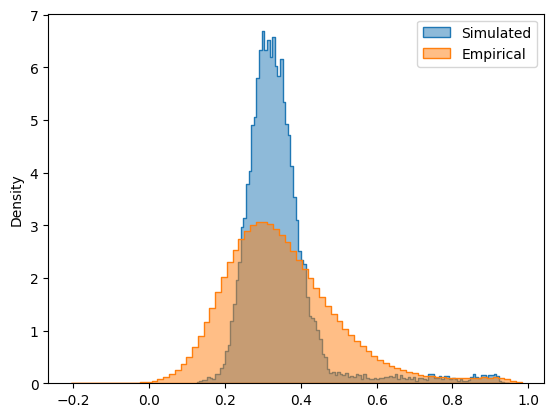

In [11]:
# plot the distributions next to each other
sns.histplot(cmaes.problem.sim_group.sim_fcd_trils[opt_idx], element='step', alpha=0.5, label='Simulated', stat='density')
ax = sns.histplot(emp_fcd_tril, element='step', alpha=0.5, label='Empirical', stat='density')
ax.legend()

# calculate KS distance
print(f"FCD KS distance = {scipy.stats.ks_2samp(emp_fcd_tril, cmaes.problem.sim_group.sim_fcd_trils[0]).statistic}")

The simulated and empirical FC and FCD are quantitatively compared using the FC correlation (`+fc_corr`) and FCD KS distance (`-fcd_ks`). These metrics, along with the other cost function components and the parameters of the optimal simulation, are stored in `cmaes.opt`:

In [12]:
cmaes.opt

index            77.000000
G                 1.269645
w_p0              0.000148
w_p1              1.246829
w_p2              1.158930
w_p3              0.248856
w_p4              0.062078
w_p5              1.340652
w_p6              0.000150
J_N0              0.265309
J_N1              0.321135
J_N2              0.306838
J_N3              0.468090
J_N4              0.002287
J_N5              0.088601
J_N6              0.068751
cost             -0.337729
+fc_corr          0.520959
-fcd_ks          -0.169955
+gof              0.351005
-fic_penalty     -0.013276
gen             119.000000
Name: 15181, dtype: float64

This optimal simulation has a better cost function and goodness-of-fit compared to the optimal point of the [map-based heterogeneous model](cmaes_het.ipynb), but at the cost of more difficult optimization and increased compute time because a higher number of generations were needed.